In [23]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv('southpark/All-seasons.csv')

# Display the first few rows of the dataset to understand its structure
dataset.head()


,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [24]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string
import re

# Data Preprocessing

# Drop rows with missing values
dataset = dataset.dropna()

# Convert text to lowercase
dataset['Line'] = dataset['Line'].str.lower()

# Remove special characters, numbers, and punctuations
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuations
    return text

dataset['Line'] = dataset['Line'].apply(clean_text)

# Tokenize the text
dataset['Tokenized'] = dataset['Line'].apply(word_tokenize)

# Split the dataset into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_data.head()

,Season,Episode,Character,Line,Tokenized
20657,16,4,Butters,no its a school night\n,"[no, its, a, school, night]"
47539,4,10,Priest Maxi,okayokay fine \n,"[okayokay, fine]"
37681,2,16,Manson,if they dont care about you would they have dr...,"[if, they, dont, care, about, you, would, they..."
15694,14,10,Dr. Chinstrap,okay okay broken toothbrush is going right her...,"[okay, okay, broken, toothbrush, is, going, ri..."
870,10,4,Kyle,you fat sun of a bitch\n,"[you, fat, sun, of, a, bitch]"


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Line'])

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['Line'])

# Extract the target labels for training and test sets
y_train = train_data['Character']
y_test = test_data['Character']

X_train_tfidf.shape, X_test_tfidf.shape

((56716, 5000), (14180, 5000))

In [27]:
# Get the top 10 most frequent characters
top_characters = train_data['Character'].value_counts().head(10).index

# Filter the training and test data to include only these characters
train_data_filtered = train_data[train_data['Character'].isin(top_characters)]
test_data_filtered = test_data[test_data['Character'].isin(top_characters)]

# Extract features again using TF-IDF for the filtered data
X_train_tfidf_filtered = tfidf_vectorizer.transform(train_data_filtered['Line'])
X_test_tfidf_filtered = tfidf_vectorizer.transform(test_data_filtered['Line'])

# Extract the target labels for filtered training and test sets
y_train_filtered = train_data_filtered['Character']
y_test_filtered = test_data_filtered['Character']

# Train the Multinomial Naive Bayes classifier on the filtered data
clf_filtered = MultinomialNB()
clf_filtered.fit(X_train_tfidf_filtered, y_train_filtered)

# Predict the characters using the filtered test set
y_pred_filtered = clf_filtered.predict(X_test_tfidf_filtered)

# Evaluate the model's performance on the filtered data
accuracy_filtered = accuracy_score(y_test_filtered, y_pred_filtered)

accuracy_filtered

0.38842368150433376

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Initialize and train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tfidf_filtered, y_train_filtered)
rf_y_pred = rf_clf.predict(X_test_tfidf_filtered)
rf_accuracy = accuracy_score(y_test_filtered, rf_y_pred)

# Initialize and train a Linear SVM classifier
svm_clf = LinearSVC(random_state=42, max_iter=10000)
svm_clf.fit(X_train_tfidf_filtered, y_train_filtered)
svm_y_pred = svm_clf.predict(X_test_tfidf_filtered)
svm_accuracy = accuracy_score(y_test_filtered, svm_y_pred)

rf_accuracy, svm_accuracy

(0.4066402232995446, 0.4070809460849126)

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearSVC(random_state=42, max_iter=10000), param_grid, cv=3, verbose=1)

# Train the model with different hyperparameters
grid_search.fit(X_train_tfidf_filtered, y_train_filtered)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Professional\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinea

{'C': 0.1, 'loss': 'squared_hinge'}

In [30]:
# Retrain the SVM model using the previously identified best hyperparameters
best_svm_clf = LinearSVC(C=0.1, loss='squared_hinge', random_state=42, max_iter=10000)
best_svm_clf.fit(X_train_tfidf_filtered, y_train_filtered)

# Predict the characters using the filtered test set
best_svm_y_pred = best_svm_clf.predict(X_test_tfidf_filtered)

# Evaluate the model's performance on the filtered data
best_svm_accuracy = accuracy_score(y_test_filtered, best_svm_y_pred)

best_svm_accuracy

0.41604230938739534

C:\Users\Professional\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


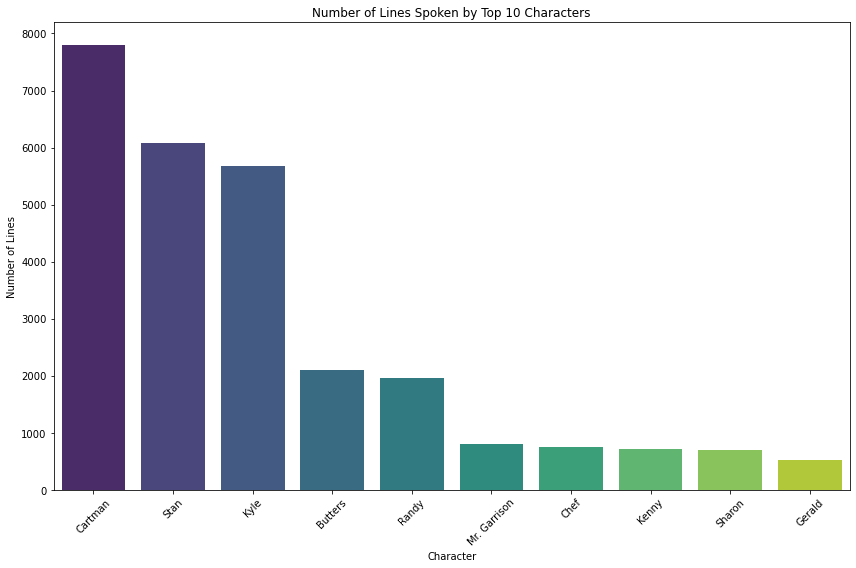

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Character frequency for top 10 characters
character_counts = train_data['Character'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(character_counts.index, character_counts.values, palette='viridis')
plt.title('Number of Lines Spoken by Top 10 Characters')
plt.ylabel('Number of Lines')
plt.xlabel('Character')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

C:\Users\Professional\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


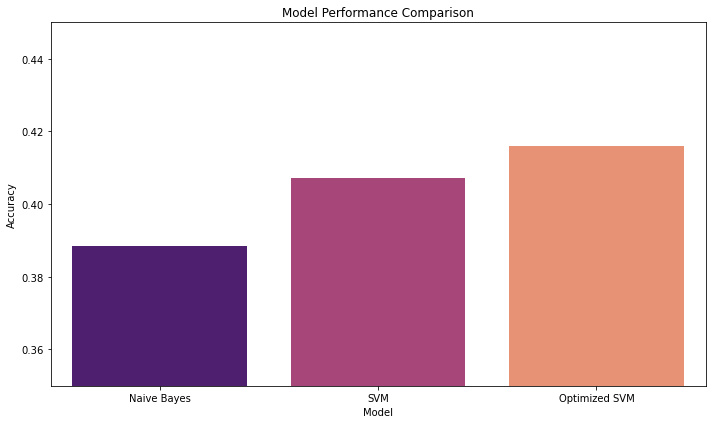

In [32]:
# Model performance comparison
models = ['Naive Bayes', 'SVM', 'Optimized SVM']
accuracies = [accuracy_filtered, svm_accuracy, best_svm_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(models, accuracies, palette='magma')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.35, 0.45)  # set y-axis limits for better visualization
plt.tight_layout()

plt.show()